<a href="https://colab.research.google.com/github/zzhining/text_data_analysis/blob/main/RNN_imdb_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imdb sentimental anlaysis

[imdb 영화평 데이터 셋](https://keras.io/api/datasets/imdb/)을 사용하여 영화평 감성분석을 하는 모델을 만들어 봅니다. 레이블은 긍정/부정으로 나뉘어져있으므로 '이진분류'문제입니다.
'분류'문제를 해결하기 위한 Classifier를 모델로 설정하고, 모델 평가는 Accuracy를 사용할 수 있습니다.



## 데이터 불러오기

In [ ]:
from tensorflow.keras.datasets.imdb import load_data

num_words = 20000    # 2만 개의 단어만 학습에 활용
(x_train, y_train), (x_test, y_test) = load_data(num_words = num_words)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((25000,), (25000,), (25000,), (25000,))

## 데이터 탐색하기

In [ ]:
# 0번 인덱스의 학습데이터 출력: label encoding된 값이 출력됨
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [ ]:
# 0번 인덱스의 학습데이터 길이: 218
len(x_train[0])

218

In [ ]:
# 0번 인덱스의 label: 0(negative)
y_train[0]

1

In [ ]:
import numpy as np
# y_train의 유일값은 0, 1(negative/positive)
np.unique(y_train)

array([0, 1])

In [ ]:
import pandas as pd

df = pd.DataFrame(x_train, columns=['review'])
df['length'] = df['review'].apply(lambda x: len(df['review'][x]))
df['label'] = y_train
df.head()

,review,length,label
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...",218,1
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...",189,0
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...",141,0
3,"[1, 4, 18609, 16085, 33, 2804, 4, 2040, 432, 1...",550,1
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...",147,0


<Axes: xlabel='length', ylabel='Count'>

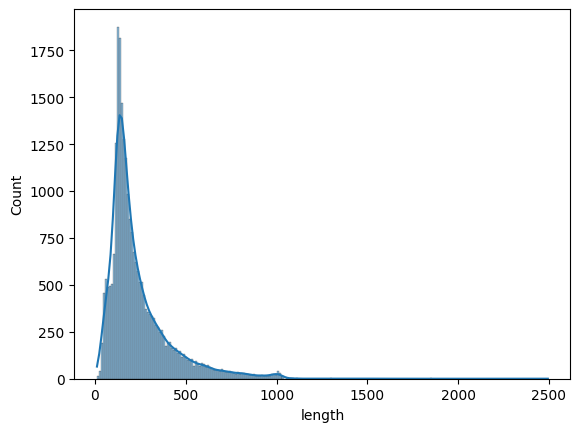

In [ ]:
import seaborn as sns
# review의 글자 수 분포 확인
sns.histplot(df['length'], kde = True)

In [ ]:
df['length'].describe()

,length
count,25000.000000
mean,238.713640
std,176.497204
min,11.000000
25%,130.000000
50%,178.000000
75%,291.000000
max,2494.000000


## 데이터 전처리

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

 # 리뷰 문장 중 300 단어만 활용
maxlen = 300
# 주어진 데이터셋을 maxlen만큼 자르고, maxlen보다 짧은 길이의 텍스트는 0을 채움
x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

In [ ]:
x_train.shape, x_test.shape

((25000, 300), (25000, 300))

## 신경망 설계하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential()
# 입력 데이터(20000개)를 128 차원 벡터로 임베딩(차원축소)
model.add(Embedding(num_words, 128))
# 양방향 LSTM
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
# 분류기
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 학습 결과를 저장하기 위한 환경 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # ./model/ 이라는 폴더가 존재하지 않으면
    os.mkdir(MODEL_DIR)           # ./model/ 이라는 폴더를 생성(mkdir())
modelpath="./model/{epoch:02d}-{val_loss:.2f}.keras"

# 학습 중 모니터링 할 조건 설정
checkpointer = ModelCheckpoint(filepath=modelpath,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

# 학습의 이른 종료를 위한 조건 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(x_train, y_train, batch_size=256, epochs=50,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6479 - loss: 0.6153
Epoch 1: val_loss improved from inf to 0.48294, saving model to ./model/01-0.48.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.6489 - loss: 0.6144 - val_accuracy: 0.7998 - val_loss: 0.4829
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8597 - loss: 0.3458
Epoch 2: val_loss improved from 0.48294 to 0.32065, saving model to ./model/02-0.32.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.8599 - loss: 0.3452 - val_accuracy: 0.8658 - val_loss: 0.3207
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9290 - loss: 0.1941
Epoch 3: val_loss did not improve from 0.32065
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.9290 - loss: 0.1941 - val_accuracy: 0.8712 - val_loss: 0.3353
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9504 - loss: 0.1395
Epoch 4: val_loss did not improve from 0.32065
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 3

<Axes: >

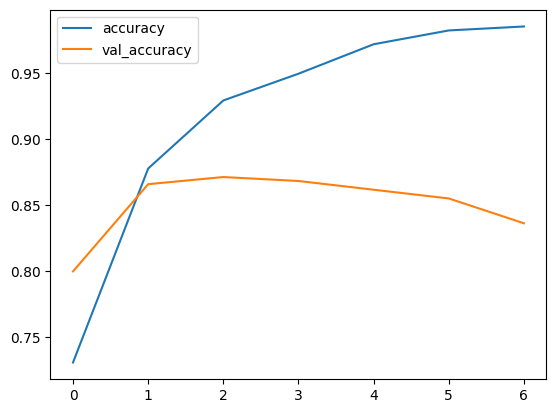

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
model.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8312 - loss: 0.5823


[0.5821216702461243, 0.8314399719238281]

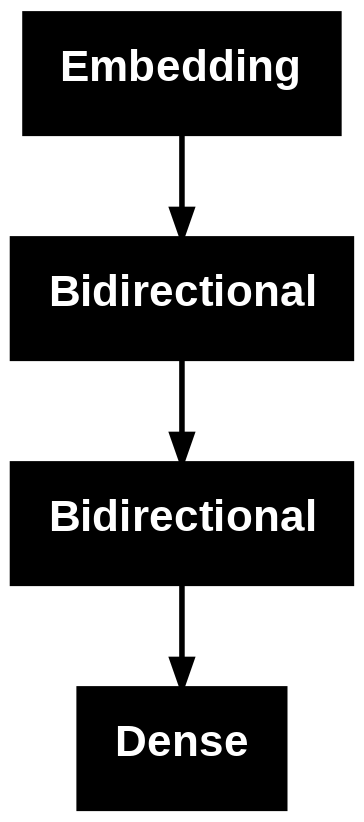

In [ ]:
# 모델 구조 plot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='graph.png')